# Setup

In [ ]:
# Mount data
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Files' location, set to your object-detection-zoo-master repository
%cd '/content/drive/My Drive/object-detection-zoo-masterr/'

/content/drive/My Drive/object-detection-zoo-masterr


In [ ]:
#Run this Cell when starting a new kernel
# This cell can be commented out after running once

# Set up virtual environment
!pip install virtualenv
!virtualenv -p /usr/bin/python3 bigdata
!source bigdata/bin/activate

# Fix bugs and install dependencies
!pip uninstall -y tensorflow
!pip install -r requirements.txt


In [ ]:
!pip install matplotlib

In [ ]:
# in case tensorflow bugs are experienced
# Try to unintall and install tensorflow-gpu 

!pip uninstall tensorflow-gpu==1.14.0
!pip install tensorflow-gpu==1.14.0

In [ ]:
#Fixing the GPU Selection
from tensorflow.python.client import device_lib

def get_available_gpus():
  local_device_protos = device_lib.list_local_devices()
  return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
tf.device('/device:GPU:0')

In [ ]:
get_available_gpus()

['/device:GPU:0']

In [ ]:
from general_utils.processing import letterbox_image_padded, decode_detection_raw
from general_utils.visualization import visualize_detection

import json
import cv2
import time
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

In [ ]:
# Load video
vidcap = cv2.VideoCapture('man-walking-with-a-laggage.mov')

In [ ]:
# Functions

def getFrame(sec):
  vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
  hasFrames,img = vidcap.read()
  return (img, hasFrames)

def generateCv2img(cv2img, detection_processed, path = None, display = False):
  fontScale = 0.7 # font & text block ratio
  for box in detection_processed:
    id, label, conf = box[0], box[1], box[2]
    x1, y1, x2, y2 = box[3], box[4], box[5], box[6]
    cv2.rectangle(cv2img,(x1,y1),(x2,y2),(0,255,0),6)

    labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,fontScale,2)
    _x1 = x1
    _y1 = y1
    _x2 = _x1 + int(labelSize[0][0] * fontScale)
    _y2 = y1 - int(labelSize[0][1]* fontScale)
    cv2.rectangle(cv2img,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
    cv2.putText(cv2img,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)

  if path != None:
    cv2.imwrite(path + str(count) + ".jpg", cv2img)

  if display: 
    cv2_imshow(cv2img)

  return cv2img

  cv2.destroyAllWindows()

##Methods to Decrease Prediction Time


In [ ]:

#Method1

#calculate the average cumulative prediction time and compare it with the target fps to fluctuate to a different fps 

def changePredTime(goal, changeTo, times, fps_list):

  avg_time=sum(times)/len(times)
  
  #changing framerate according to prediction time average so far
  if avg_time > (1/24) :
    frame_rate= changeTo
  else:
    frame_rate= goal

  fps_list.append(frame_rate)

  return frame_rate

#Method2

#if prediction time at n-1 increased since n-2 , fluctuate to a different fps; if prediction time at n-1 is decreased since n-2, keep the target fps

def changePredTime2(goal, changeTo, times, fps_list, count):

  if (times[count-1]-times[count-2]) >= 0:
    frame_rate= changeTo
  else:
    frame_rate= goal

  fps_list.append(frame_rate)

  return frame_rate

##SSD 512

In [ ]:

from detectors.ssd import SSD512
# Load the model
detector = SSD512(weights='model_weights/SSD_VOC0712_VGG16_512x512.h5')

# Parameters
sec = 0
fps = 24
frameRate = 1 / fps # interval between frames
goal=1/24
changeTo=1/20     #one of the values from [1/5, 1/10, 1/15, 1/20] can be selected as changeTo variable value
count = 0
success = getFrame(sec)
images = []
cv2imgs = []
times = []
results = []
result_imgs = []
fps_list=[]
fps_list.append(frameRate)
modelName = "ssd512"
path = './output/'+ modelName + str(fps) + '/'

# Convert the video to frames and make prediction
while success:
  count = count + 1
  sec = sec + frameRate
  sec = round(sec, 2)
  image ,success = getFrame(sec)
  
  if not success:
    continue

  # convert np array back to image
  cv2img = image
  cv2imgs.append(image)
  image = Image.fromarray(image) 
  images.append(image)

  # Time and make prediction
  x_query, x_meta = letterbox_image_padded(image, size=detector.model_img_size)
  start = time.time()
  detection_raw = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
  end = time.time()
  detection_processed = decode_detection_raw(detection_raw, x_meta, detector.classes)
  
  # Generate and save the result image
  result_img = generateCv2img(cv2img, detection_processed, path = path)        #, display = False)
  result_imgs.append(result_img)

  # Collect the result
  results.append(detection_processed)
  times.append(end - start)

  # method1
  # changing fps if there is lag
  # frameRate=changePredTime(goal, changeTo, times, fps_list)

  #method2
  #changing fps if there is lag
  if len(times)>1:
    frameRate=changePredTime2(goal, changeTo, times, fps_list, count)


print("Number of frames:", len(times))

# Time summary    
summary = [max(times), min(times), sum(times)/len(times) ]
print("Prediction time list", times)
print("Max:", max(times))
print("Min:", min(times))
print("Avg:", sum(times)/len(times))

# Save intervals 
# data = json.dumps(times)

# with open(path + 'intervals.json', 'w') as f:
#     json.dump(data, f)
# # Save summary
# data = json.dumps(summary)
# with open(path + 'time_summary.json', 'w') as f:
#     json.dump(data, f)

  
# Confidence summary
conf = []
for elm in results:
  if len(elm) != 0:
    conf.append(elm[0][2])

confFps = {}
confFps['rawConfList'] = conf
confFps['maxConf'] = max(conf)
confFps['minConf'] = min(conf)
confFps['avgConf'] = sum(conf)/len(conf)
print('max(conf)', confFps['maxConf'])
print('min(conf)', confFps['minConf'])
print('avgConf', confFps['avgConf'])

Number of frames: 145
Prediction time list [4.553586483001709, 0.09069180488586426, 0.09317588806152344, 0.09085226058959961, 0.08978962898254395, 0.09668350219726562, 0.0919189453125, 0.09146881103515625, 0.0896451473236084, 0.08997178077697754, 0.09083199501037598, 0.09359359741210938, 0.09180474281311035, 0.0912313461303711, 0.09411191940307617, 0.08987140655517578, 0.09252023696899414, 0.09335970878601074, 0.09597992897033691, 0.09168291091918945, 0.0920865535736084, 0.09574770927429199, 0.09595656394958496, 0.09185218811035156, 0.09107255935668945, 0.09033608436584473, 0.09632587432861328, 0.09784221649169922, 0.09337568283081055, 0.0922853946685791, 0.09280967712402344, 0.09882545471191406, 0.09572958946228027, 0.09136319160461426, 0.09058284759521484, 0.09104013442993164, 0.09101414680480957, 0.08993124961853027, 0.09069013595581055, 0.09054684638977051, 0.09230470657348633, 0.08980631828308105, 0.09628605842590332, 0.09464597702026367, 0.08954548835754395, 0.0902869701385498, 0

In [ ]:
# Convert images back to video
import cv2
import numpy as np
import glob
 
img_array = []
for filename in  result_imgs:
    # img = cv2.imread(filename)
    img=filename
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('test.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 24, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
import pandas as pd
#Results of using only 24 fps
fps_24 = pd.DataFrame(
    # {'FPS': fps_list,
     {'Times24': times,
     'Confidence24': conf 
    })
fps_24

,Times24,Confidence24
0,2.678609,0.999936
1,0.091036,0.999542
2,0.085801,0.999648
3,0.083680,0.999727
4,0.073761,0.999118
...,...,...
198,0.092955,0.999885
199,0.089470,0.999883
200,0.084922,0.999881
201,0.075243,0.999816


In [ ]:

#Results of using both 20 and 24 fps
fps_2420 = pd.DataFrame(
    {'FPS2420': fps_list,
     'Times2420': times,
     'Confidence2420': conf 
    })
fps_2420

,FPS2420,Times2420,Confidence2420
0,0.041667,2.592643,0.999936
1,0.041667,0.096851,0.999542
2,0.041667,0.095854,0.999648
3,0.041667,0.089719,0.999727
4,0.041667,0.080680,0.999118
...,...,...,...
176,0.041667,0.090941,0.999888
177,0.041667,0.085487,0.999883
178,0.041667,0.080601,0.999889
179,0.050000,0.081089,0.999887


In [ ]:
#Results of using both 24 and 15
fps_2415 = pd.DataFrame(
    {'FPS2415': fps_list,
     'Times2415': times,
     'Confidence2415': conf 
    })
fps_2415

,FPS2415,Times2415,Confidence2415
0,0.041667,2.312481,0.999936
1,0.041667,0.089208,0.999542
2,0.041667,0.089113,0.999648
3,0.066667,0.089637,0.999727
4,0.041667,0.085980,0.999020
...,...,...,...
143,0.066667,0.096903,0.999624
144,0.041667,0.090855,0.999885
145,0.066667,0.098145,0.999883
146,0.041667,0.096037,0.999816


In [ ]:
#Results of using both 24 and 10
fps_2410 = pd.DataFrame(
    {'FPS2410': fps_list,
     'Times2410': times,
     'Confidence2410': conf 
    })
fps_2410

,FPS2410,Times2410,Confidence2410
0,0.041667,2.072683,0.999936
1,0.041667,0.090904,0.999542
2,0.041667,0.089413,0.999648
3,0.041667,0.084636,0.999727
4,0.041667,0.083902,0.999118
...,...,...,...
114,0.100000,0.083247,0.999389
115,0.100000,0.094132,0.999624
116,0.041667,0.083249,0.999883
117,0.100000,0.083507,0.999889


In [ ]:
#Results of using both 24 and 5
fps_list
fps_2405 = pd.DataFrame(
    {'FPS2405': fps_list,
     'Times2405': times,
     'Confidence2405': conf 
    })
fps_2405

,FPS2405,Times2405,Confidence2405
0,0.041667,1.806911,0.999936
1,0.041667,0.089367,0.999542
2,0.200000,0.089733,0.999648
3,0.041667,0.089130,0.996479
4,0.200000,0.091145,0.995736
...,...,...,...
62,0.200000,0.074349,0.999941
63,0.041667,0.068938,0.999786
64,0.200000,0.072880,0.999850
65,0.200000,0.073711,0.999834


In [ ]:
fps_2415.to_excel('2415method2.xlsx')
fps_2405.to_excel('2405method2.xlsx')
fps_2410.to_excel('2410method2.xlsx')
fps_2420.to_excel('2420method2.xlsx')
fps_20.to_excel('24method2.xlsx')

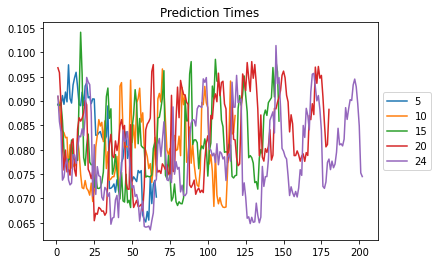

In [ ]:
#method2
# !pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
plt.figure()

plt.plot(fps_2405.iloc[1:205].Times2405) 
plt.plot(fps_2410.iloc[1:205].Times2410)
plt.plot(fps_2415.iloc[1:205].Times2415)
plt.plot(fps_2420.iloc[1:205].Times2420)
plt.plot(fps_24.iloc[1:205].Times24)

plt.title('Prediction Times') 
plt.legend(["5", "10","15", "20","24"],loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()